In [1]:
from segmenter_api.utils.file import get_project_dir

%cd {get_project_dir()}
print(get_project_dir())

/home/yoshino_teppei/ghq/github.com/Tyaba/segmentator-api
/home/yoshino_teppei/ghq/github.com/Tyaba/segmentator-api


In [2]:
from pathlib import Path

import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

from segmenter_api.utils.image import draw_bbox

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

/home/yoshino_teppei/ghq/github.com/Tyaba/segmentator-api/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
image_path = Path("tests/data/abema_water.png")
image = Image.open(image_path).convert("RGB")
prompts = [f"{task_prompt}plastic bottle", f"{task_prompt}green character"]

In [6]:
inputs = processor(text=prompts, images=[image] * len(prompts), return_tensors="pt").to(
    device, torch_dtype
)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3,
    do_sample=False,
)

generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=False)

In [9]:
generated_texts

['</s><s>plastic bottle<loc_246><loc_182><loc_506><loc_723></s><pad>',
 '</s><s><s><s>green character<loc_288><loc_529><loc_489><loc_716></s>']

In [10]:
parsed_answers = [
    processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height),
    )
    for generated_text in generated_texts
]

print(parsed_answers)


[{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[252.416015625, 186.8800048828125, 518.656005859375, 740.864013671875]], 'bboxes_labels': ['plastic bottle'], 'polygons': [], 'polygons_labels': []}}, {'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[295.42401123046875, 542.2080078125, 501.2480163574219, 733.696044921875]], 'bboxes_labels': ['green character'], 'polygons': [], 'polygons_labels': []}}]


In [13]:
parsed_answers[0]

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[252.416015625,
    186.8800048828125,
    518.656005859375,
    740.864013671875]],
  'bboxes_labels': ['plastic bottle'],
  'polygons': [],
  'polygons_labels': []}}

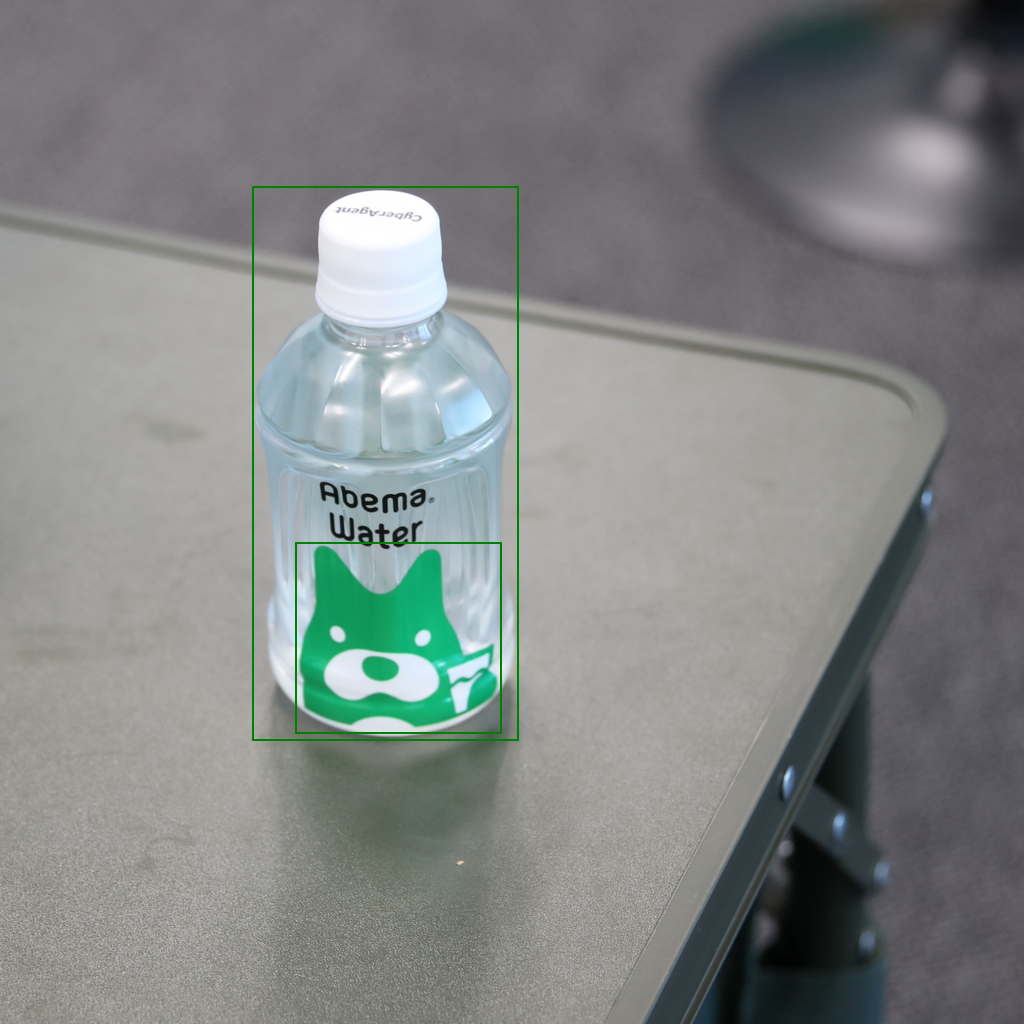

In [12]:
draw_bbox(
    image=image,
    bbox=parsed_answers[1]["<OPEN_VOCABULARY_DETECTION>"]["bboxes"][0],
    color="green",
)
